In [355]:
from __future__ import print_function

from time import time
import logging
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC,LinearSVC
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from PIL import Image
import os
import sys
sys.path.insert(0,'../python_scripts')
import numpy as np
from tqdm import tqdm_notebook as tq
import importlib
import meta
import utils
importlib.reload(utils)
from sklearn.manifold import Isomap
from time import time
import warnings
warnings.filterwarnings('ignore')
from keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.layers import *
import gc
from sklearn.externals import joblib
from sklearn.manifold import TSNE
import os
from sklearn.multiclass import OneVsRestClassifier,OneVsOneClassifier
from sklearn.metrics import log_loss

In [277]:
### GENERATE RESNET OUTPUT FROM CROPPED IMAGES

In [278]:
cropped_images = '../cropped_train/_gen/'
cropped_images_test = '../cropped_test/_gen/'
cropped_features_train = '../cropped_r50/train/'
cropped_features_test = '../cropped_r50/test/'

In [41]:
def generate_cropped_features_R50(cropped_path,output_path,img_size=(256,256)):
    print('fixed variables img_size=(256,256)')
    import collections
    data = collections.defaultdict(int)
    classes = os.listdir(cropped_path)
    if not os.listdir(output_path):
        for c in classes:
            utils.mk(output_path+c)
    model1 = ResNet50(include_top=False, input_shape=(3,img_size[0],img_size[1]))
    model2 = Model(model1.input, model1.layers[-2].output)
    img_a = Input(shape=(3,img_size[0],img_size[1]))
    x = model2(img_a)
    x = GlobalMaxPooling2D()(x)
    model = Model(img_a, x)
    del model1,model2
    gc.collect()
    f = []
    for c in classes:
        data[c]=os.listdir(cropped_path+c)
        for img_name in os.listdir(output_path+c):
            f.append(img_name)
    for key in data.keys():
        for img_name in tq(data[key]):
            if img_name not in f:
                img = img_to_array(Image.open(cropped_path+key+'/'+img_name).resize(size=img_size))
                img = np.expand_dims(img,axis=0)
                y = model.predict(img)[0]
                out_name = str(output_path +key +'/'+img_name.split('.')[0])
                utils.save_array(y, out_name)
    print('Done ! ')
    


In [4]:
generate_cropped_features_R50(cropped_images,cropped_features_train)

fixed variables img_size=(256,256)








Done ! 


In [42]:
generate_cropped_features_R50(cropped_images_test,cropped_features_test)

fixed variables img_size=(256,256)



Exception in thread Thread-20:
Traceback (most recent call last):
  File "D:\Software\Anaconda3\lib\threading.py", line 914, in _bootstrap_inner
    self.run()
  File "D:\Software\Anaconda3\lib\site-packages\tqdm\_tqdm.py", line 102, in run
    for instance in self.tqdm_cls._instances:
  File "D:\Software\Anaconda3\lib\_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration











Done ! 


### LOAD RESNET OUTPUTS

In [321]:
def load_R50_data(cropped_features_path):
    classes = os.listdir(cropped_features_path)
    f = [{'c':c,'f':[utils.load_array(cropped_features_path+c+'/'+f.split('.')[0]) for f in os.listdir(cropped_features_path+c)]} for c in classes]
    return f

In [322]:
f = load_R50_data(cropped_features_train)

In [323]:
class Feature_class():
    def __init__(self,c,data):
        self.c = c
        self.data = np.array(data)
        self.label = meta.get_classes_dictionary()[c]
        self.label_vector = utils.to_categorical(meta.get_classes_dictionary()[c],8)
    def get_data(self):
        return self.data
    def get_class(self):
        return self.c
    def get_label(self):
        return np.array([self.label for _ in range(len(self.data))])
    def get_vector_label(self):
        return np.array([self.label_vector for _ in range(len(self.data))])

In [324]:
features = []
for i in range(len(f)):
    features.append(Feature_class(f[i]['c'],f[i]['f']))

In [325]:
features[0].get_data().shape

(2013, 2048)

In [326]:
features[0].get_label()

array([2, 2, 2, ..., 2, 2, 2])

### CALCULATE ISOMAP FOR EACH CLASS + FULL AND SAVE IT

In [29]:
for i in range(len(f)):
    n_components = 100
    t0 = time()
    pca = Isomap(n_components=n_components).fit(features[i].get_data())
    print("done in %0.3fs" % (time() - t0))
    joblib.dump(pca, './models/isomap_'+features[i].get_class()+'.pkl') 

done in 22.375s
done in 20.161s
done in 20.205s
done in 20.758s
done in 21.717s
done in 15.462s
done in 20.936s
done in 21.688s


In [12]:
n_components = 100
t0 = time()
data = np.concatenate([features[i].get_data() for i in range(len(f))])
print(data.shape)
pca = Isomap(n_components=n_components).fit(data)
print("done in %0.3fs" % (time() - t0))
joblib.dump(pca, './models/isomap_full.pkl') 

(15929, 2048)
done in 2125.677s


['./models/isomap_full.pkl']

### CALCULATE PCA FOR EACH CLASS + FULL AND SAVE IT

In [9]:
for i in range(len(f)):
    n_components = 100
    t0 = time()
    data = features[i].get_data()
    print(data.shape)
    pca = PCA(n_components=n_components).fit(data)
    print("done in %0.3fs" % (time() - t0))
    joblib.dump(pca, './models/pca_'+features[i].get_class()+'.pkl') 

(2013, 2048)
done in 0.814s
(2014, 2048)
done in 0.329s
(1986, 2048)
done in 0.317s
(1986, 2048)
done in 0.342s
(2000, 2048)
done in 0.318s
(1916, 2048)
done in 0.343s
(2007, 2048)
done in 0.346s
(2007, 2048)
done in 0.316s


In [11]:
n_components = 100
t0 = time()
data = np.concatenate([features[i].get_data() for i in range(len(f))])
print(data.shape)
pca = PCA(n_components=n_components).fit(data)
print("done in %0.3fs" % (time() - t0))
joblib.dump(pca, './models/pca_full.pkl') 

(15929, 2048)
done in 2.470s


['./models/pca_full.pkl']

### CALCULATE TSNE FOR EACH CLASS + FULL AND SAVE IT

In [10]:
for i in range(len(f)):
    t0 = time()
    data = features[i].get_data()
    print(data.shape)
    pca = TSNE(n_components=3).fit(data)
    print("done in %0.3fs" % (time() - t0))
    joblib.dump(pca, './models/tsne_'+features[i].get_class()+'.pkl') 

(2013, 2048)
done in 32.481s
(2014, 2048)
done in 37.180s
(1986, 2048)
done in 30.676s
(1986, 2048)
done in 30.794s
(2000, 2048)
done in 34.039s
(1916, 2048)
done in 34.660s
(2007, 2048)
done in 35.375s
(2007, 2048)
done in 32.740s


In [9]:
t0 = time()
data = np.concatenate([features[i].get_data() for i in range(len(f))])
print(data.shape)
pca = Isomap(n_components=3).fit(data)
print("done in %0.3fs" % (time() - t0))
joblib.dump(pca, './models/tsne3_full.pkl') 

(15929, 2048)
done in 1227.845s


['./models/tsne3_full.pkl']

### TEST WITH MULTIPLE BOXES 

### TIME FOR SVM

### PCA


### PROJECT ALL DATA ON EIGENVECTORS

In [327]:
data = np.concatenate([features[i].get_data() for i in range(len(f))])
label = np.concatenate([features[i].get_label() for i in range(len(f))])

In [328]:
print(data.shape,label.shape)

(15987, 2048) (15987,)


In [329]:
pca_full = joblib.load('./models/pca_full.pkl')
data_pca = np.array([pca_full.transform(f) for f in data])

In [330]:
label[1900:2100],label[3800:4100]

(array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]),
 array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3

### CORRELATION MATRIX

In [13]:
corr = np.dot(data_pca.mean(axis=1).T,data_pca.mean(axis=1))
corr.shape

(100, 100)

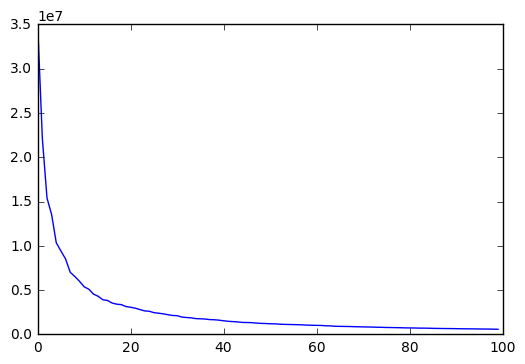

In [14]:
x = [corr[i,i] for i in range(100)]
plt.plot(range(100),x)
plt.show()

### USE SVM WITH PCA

### LOAD TEST DATA

In [331]:
f_test = load_R50_data(cropped_features_test)
features_test = []
for i in range(len(f_test)):
    features_test.append(Feature_class(f_test[i]['c'],f_test[i]['f']))

In [332]:
data_test = np.concatenate([features_test[i].get_data() for i in range(len(f_test))])
data_pca_test = np.array([pca_full.transform(f) for f in data_test]).mean(axis=1)
label_test = np.concatenate([features_test[i].get_label() for i in range(len(f_test))])

In [333]:
label_test[0]

2

In [334]:
label_test_vector = np.concatenate([features_test[i].get_vector_label() for i in range(len(f_test))])

In [335]:
label_test_vector.shape,label_test_vector[0]

((4025, 8), array([ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]))

In [336]:
print(label.shape,data_pca_test.shape)

(15987,) (4025, 100)


### SVM WITH PCA : array([[370,  49]])

In [69]:
results_train = [0]
results_test = [0]
save_params = []
cls = []

data = np.concatenate([features[i].get_data() for i in range(len(f))])
data_pca = np.array([pca_full.transform(f) for f in data]).mean(axis=1)
print(data_pca.shape)
Z = 49
t0 = time()
pca_d_Z = data_pca[:,:Z]
#param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
#              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
#clf = OneVsRestClassifier(GridSearchCV(SVC(kernel='rbf',max_iter=370,probability=True),param_grid))
clf = OneVsOneClassifier(SVC(kernel='rbf',max_iter=370,probability=True))
clf = clf.fit(pca_d_Z, label)
data_pca_test_Z = data_pca_test[:,:Z]
a = clf.score(pca_d_Z, label)
results_train.append(a)
b = clf.score(data_pca_test_Z, label_test)
results_test.append(b)
save_params.append([i,Z])
print(a,b)

(15987, 100)
0.944204666291 0.866335403727


In [231]:
joblib.dump(clf,'./models/ovo_SVC_k=rbf.pkl')

['./models/ovo_SVC_k=rbf.pkl']

In [337]:
clf = joblib.load('./models/ovo_SVC_k=rbf.pkl')

In [338]:
def N_acc(prediction,label_test,N=3):
    L = len(prediction)
    count=0
    for i,row in enumerate(prediction):
        if label_test[i] in np.argpartition(row, -N)[-N:][::-1]:
            count+=1
    print(count/L)
        

In [499]:
prediction[0],label_test[0]

(array([  3.00000000e+000,   2.00000000e+000,   5.00000000e+000,
          4.00000000e+000,   6.00000000e+000,   1.00000000e+000,
         -4.22244363e-126,   7.00000000e+000]), 2)

In [339]:
N_acc(prediction,label_test,N=2)

0.9391304347826087


In [516]:
def find_right_alpha(row,alpha,beta,theta,limit):
    row = f(row,alpha,beta,theta)
    row = row/row.sum()
    ind = row <= limit
    row[ind]=limit
    row = row/row.sum()
    return row

def normalise_to_prob(prediction,label_test,N=2,MIN=0.00001,alpha=0.52230769,beta=20.83916667,theta=0.1 ,limit=1e-05):
    predi = []
    for row,l in zip(prediction,label_test):
        #print(row)
        #print()
        #order = sorted(row,reverse=True)
        #print(order)
        r = find_right_alpha(row,alpha,beta,theta,limit)
        print(r,r.sum())
        break
        #print(r)
        predi.append(r)
    return np.array(predi)

def f(row,alpha,beta,theta):#np.log(42**np.array([3, 4]))/np.log(42)
    print(row)
    order = sorted(row,reverse=True)
    print(order)
    r = [[1] for i in range(8)]
    homo = np.linspace(1,1+theta,num=8)[::-1]
    print(homo)
    for i,j in zip(homo,order):
        n = np.where(row==j)[0][0]
        #print(n,i)
        r[n].append(i)
    r = np.array([np.array(x).max() for x in r])
    print(r)
    return np.power(np.exp(np.multiply(row,r))/beta,1+alpha)
    #return np.power(row,1+alpha)
    

In [517]:
predi = normalise_to_prob(prediction,label_test)

[  3.00000000e+000   2.00000000e+000   5.00000000e+000   4.00000000e+000
   6.00000000e+000   1.00000000e+000  -4.22244363e-126   7.00000000e+000]
[7.0, 6.0, 5.0, 4.0, 3.0, 2.0, 1.0, -4.2224436287317646e-126]
[ 1.1         1.08571429  1.07142857  1.05714286  1.04285714  1.02857143
  1.01428571  1.        ]
[ 1.04285714  1.02857143  1.07142857  1.05714286  1.08571429  1.01428571
  1.          1.1       ]
[  7.92283523e-04   1.55069803e-04   2.35643613e-02   4.22788764e-03
   1.37175747e-01   3.17002926e-05   9.99996768e-06   8.34042951e-01] 1.0


In [495]:
logs = []
a = np.linspace(0.3,0.7,num=10)
b = np.linspace(10,30,num=25)
c = np.linspace(0.1,5,num=5)
params = []
d = tq(total=len(a)*len(b)*len(c))
for i in a:
    for j in b:
        for k in c:
            predi = normalise_to_prob(prediction,label_test,alpha=i,beta=j,theta=k)
            logs.append(log_loss(label_test,predi))
            params.append([i,j,k])
            d.update()
params = np.array(params)
logs = np.array(logs)
min_loss = logs.min()
print(params[np.where(logs==min_loss)])
print(logs.min())


[[  0.52230769  20.83916667   0.1       ]
 [  0.52230769  20.83916667   1.325     ]
 [  0.52230769  20.83916667   2.55      ]
 [  0.52230769  20.83916667   3.775     ]
 [  0.52230769  20.83916667   5.        ]]
0.61908914546


### SVM WITH ISOMAP : Z = 40-50 AND ITER : 300-400

In [16]:
## GENERATE DATA 
isomap = joblib.load('./models/isomap_full.pkl')

data_train = np.concatenate([features[i].get_data() for i in range(len(f))])

label_train = np.concatenate([features[i].get_label() for i in range(len(f))])

data_test = np.concatenate([features_test[i].get_data() for i in range(len(f_test))])

label_test = np.concatenate([features_test[i].get_label() for i in range(len(f_test))])

In [17]:
data_train_iso = np.array([isomap.transform(f) for f in tq(data_train)])
data_test_iso = np.array([isomap.transform(f) for f in tq(data_test)])

In [20]:
import pickle
data_train_iso_r = data_train_iso.mean(axis=1)
data_test_iso_r = data_test_iso.mean(axis=1)
pickle.dump( data_train_iso_r, open( "data_train_iso_r.p", "wb" ) )
pickle.dump( data_test_iso_r, open( "data_test_iso_r.p", "wb" ) )

In [21]:
## VERIFICATIOn
print(data_train_iso_r.shape,data_test_iso_r.shape,label_train.shape,label_test.shape)

(15987, 100) (4025, 100) (15987,) (4025,)


In [34]:
Z = 45
t0 = time()
np.random.seed(15)
pca_d_Z = data_train_iso_r[:,:Z]
#param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
 #             'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
#clf = OneVsRestClassifier(GridSearchCV(SVC(kernel='rbf',max_iter=350,probability=True),param_grid))
clf = OneVsOneClassifier(SVC(kernel='rbf',max_iter=2000,probability=True))
clf = clf.fit(pca_d_Z, label_train)
data_pca_test_Z = data_test_iso_r[:,:Z]

In [35]:
print(clf.score(pca_d_Z, label_train))
print(clf.score(data_pca_test_Z, label_test))

0.889848001501
0.276770186335
